In [21]:
###----------------
###Import Libraries
###----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###--------------------
### Some hyperparameter
###--------------------

MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

In [22]:
default_path = "/content/drive/MyDrive/Deep learning project/"

In [23]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)

    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)

    return train_acc, test_acc

In [24]:
# estimate 95% confidence interval on error  Z_score = 1.96
"""
This part of the formula calculates the standard error of the sample proportion,
which represents the standard deviation of the sampling distribution of sample proportions
"""

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term

    return lb, ub

In [25]:
# read in our data and preprocess it

df = pd.read_csv(default_path+"fake_or_real_news.csv")
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [26]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


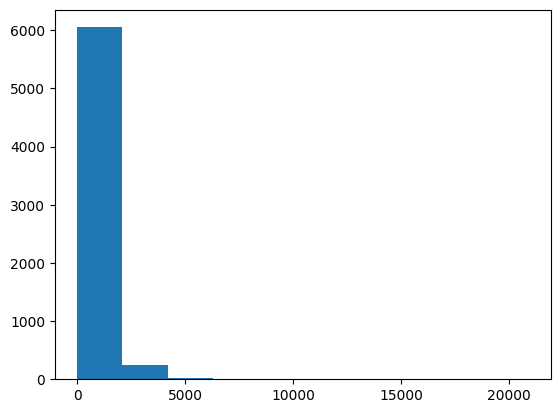

In [27]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

### Naive Bayes

In [28]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word",
                             binary = True,
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names_out())

In [29]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [30]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB()

In [31]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 93.69%
Testing Accuracy: 89.74%


In [32]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 88.07%-91.41%


In [33]:
# vectorize the text samples into a 2D integer tensor

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences,
                     maxlen=MAX_SEQUENCE_LENGTH,
                     padding='pre',
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 98817 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [34]:
# split the data into a training set and a validation set

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data,
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1),
                                                  test_size=TEST_SPLIT)

In [36]:
# build a 1D convnet with global maxpooling

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM,
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),

        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 300)         7500300   
                                                                 
 conv1d_1 (Conv1D)           (None, 4996, 128)         192128    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 32)                4128      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                      

In [37]:
# train the model

history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
40/40 [==============================] - 15s 335ms/step - loss: 0.6545 - accuracy: 0.6067 - val_loss: 0.4969 - val_accuracy: 0.7972
Epoch 2/10
40/40 [==============================] - 13s 324ms/step - loss: 0.3564 - accuracy: 0.8520 - val_loss: 0.2565 - val_accuracy: 0.9006
Epoch 3/10
40/40 [==============================] - 13s 323ms/step - loss: 0.1729 - accuracy: 0.9424 - val_loss: 0.2119 - val_accuracy: 0.9006
Epoch 4/10
40/40 [==============================] - 12s 314ms/step - loss: 0.0881 - accuracy: 0.9742 - val_loss: 0.1796 - val_accuracy: 0.9211
Epoch 5/10
40/40 [==============================] - 13s 321ms/step - loss: 0.0394 - accuracy: 0.9901 - val_loss: 0.1125 - val_accuracy: 0.9550
Epoch 6/10
40/40 [==============================] - 12s 298ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 0.1114 - val_accuracy: 0.9582
Epoch 7/10
40/40 [==============================] - 13s 335ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1111 - val_accuracy: 0.9597

In [38]:
# all possible parameters history stores
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

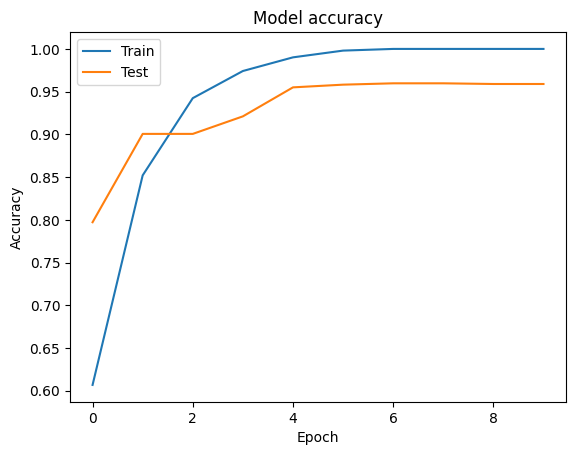

In [39]:
# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

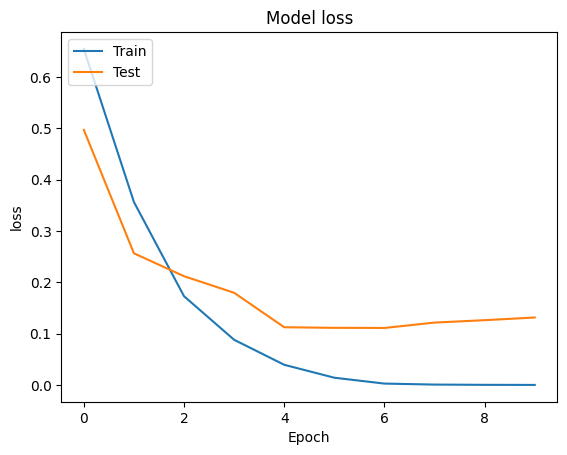

In [40]:
# Plot training & validation accuracy values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [41]:
# evaluate model

train_acc, test_acc = evaluate_model(lambda x: np.rint(model.predict(x)),
                                     x_train,
                                     y_train,
                                     x_val,
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

40/40 [==============================] - 1s 19ms/step
Training Accuracy: 100.00%
Testing Accuracy: 95.90%


In [42]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 94.80%-96.99%


In [43]:
# Save the model

model.save(default_path+'model_1DCNN.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
#!pip install gradio   #uncomment this to install gradio

import gradio as gr

def predict_news(text):
    # preprocess the text
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    data = pad_sequences(sequences,
                         maxlen=MAX_SEQUENCE_LENGTH,
                         padding='pre',
                         truncating='pre')

    # predict the class
    prediction = model.predict(data)
    label = "Fake" if prediction[0] < 0.5 else "Real"

    return label

demo = gr.Interface(
    fn=predict_news,
    inputs=gr.Textbox(),
    outputs="label",
)

demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://be1a085b833aa08910.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
